### Multi-Conditional Graph Variational Autoencoder

In [1]:
import torch
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [2]:
from data.dataset import QM9GraphDataset
from utils.datautils import create_data_loaders
from mgcvae import MGCVAE
from trainer import MGCVAETrainer
from utils.trainutils import load_from_checkpoint

In [3]:
dataset = QM9GraphDataset(csv_path='./data/qm9_bbbp.csv')

Processing...


Processing 2142 molecules...
Successfully processed 2142 molecules, failed: 0


Done!


In [4]:
train_loader, val_loader, test_loader = create_data_loaders(dataset, batch_size=4)

Dataset splits — Train: 1713, Val: 214, Test: 215


In [ ]:
# Load the best model from training
model, optimizer_state, scheduler_state, checkpoint = load_from_checkpoint(
    'checkpoints/mgcvae/best_model.pth',
    device=device
)
loaded = True

# Model is ready for inference!
# You can also access training history:
print(f"\nTraining stopped at epoch: {checkpoint['epoch']}")
print(f"Final validation loss: {checkpoint['best_val_loss']:.4f}")

Model loaded from checkpoints/mgcvae/best_model.pth
Epoch: 10, Best Val Loss: 0.8335

Training stopped at epoch: 10
Final validation loss: 0.8335


### If we haven't Trained yet

In [6]:
if not loaded:
    model_config = {
        'node_dim': 29,
        'edge_dim': 6,
        'latent_dim': 32,
        'hidden_dim': 64,
        'num_properties': 1,
        'num_layers': 3,
        'heads': 4,
        'max_nodes': 20,
        'beta': 0.01,      # Start with low KL weight
        'gamma': 1.0,      # Property prediction weight
        'dropout': 0.1
    }
    model = MGCVAE(**model_config).to(device)

In [ ]:
trainer = MGCVAETrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    lr=1e-3,
    device=device,
    save_dir='checkpoints/mgcvae'
)

In [ ]:
trainer.load_optimizer_scheduler(optimizer_state, scheduler_state)

Starting MGCVAE training from epoch 11 to 15
Model parameters: 105,216
Device: mps

Epoch 11/15


Validation: 100%|██████████| 54/54 [00:56<00:00,  1.04s/it]


New best model saved! Val loss: 0.8356
Train Loss: 0.8907 | Val Loss: 0.8356
Recon: 0.7829 | KL: 2.8186 | Prop: 0.0796
LR: 1.00e-03 | Patience: 0/30

Epoch 12/15


Validation: 100%|██████████| 54/54 [00:54<00:00,  1.00s/it]


Train Loss: 0.8888 | Val Loss: 0.8566
Recon: 0.7803 | KL: 2.9338 | Prop: 0.0792
LR: 1.00e-03 | Patience: 1/30

Epoch 13/15


Validation: 100%|██████████| 54/54 [00:37<00:00,  1.43it/s]


Train Loss: 0.8817 | Val Loss: 0.8434
Recon: 0.7739 | KL: 2.8847 | Prop: 0.0789
LR: 1.00e-03 | Patience: 2/30

Epoch 14/15


Validation: 100%|██████████| 54/54 [00:55<00:00,  1.02s/it]


New best model saved! Val loss: 0.8317
Train Loss: 0.8828 | Val Loss: 0.8317
Recon: 0.7750 | KL: 2.8207 | Prop: 0.0796
LR: 1.00e-03 | Patience: 0/30

Epoch 15/15


Validation: 100%|██████████| 54/54 [01:00<00:00,  1.12s/it]


Train Loss: 0.8866 | Val Loss: 0.8621
Recon: 0.7793 | KL: 2.8275 | Prop: 0.0789
LR: 1.00e-03 | Patience: 1/30


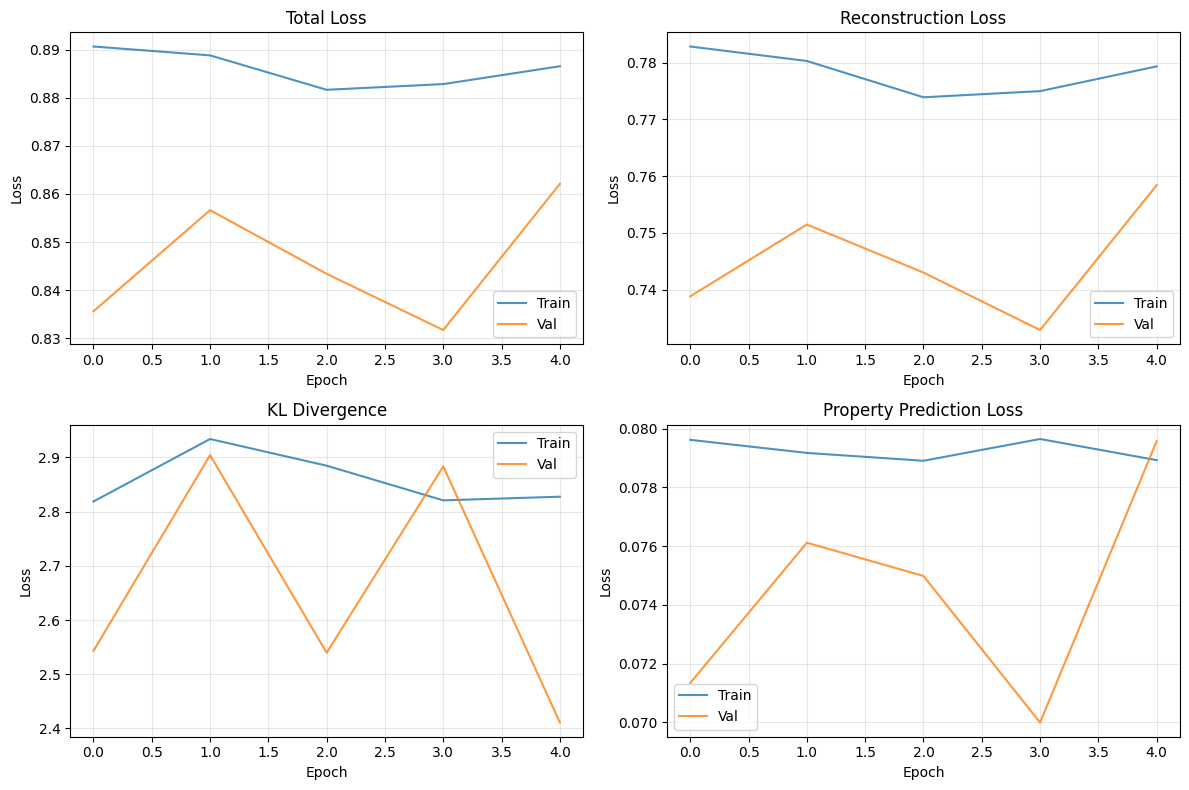

Training completed!


In [8]:
train_metrics, val_metrics = trainer.train(num_epochs=5, start_epoch=checkpoint['epoch']+1)

### Metrics

In [9]:
from utils.metrics import (
    evaluate_property_prediction,
    evaluate_reconstruction_and_kl,
    evaluate_novelty_diversity,
    evaluate_conditioning_latent
)

In [10]:
from utils.inference import (
    batch_logits_to_molecules,
    evaluate_generation_quality
)

In [11]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [12]:
_ = evaluate_property_prediction(model, val_loader, device)
_ = evaluate_reconstruction_and_kl(model, val_loader, device)

Property Prediction MSE: 0.3663
Avg Reconstruction Loss: 0.7584
Avg KL Divergence: 2.4110


In [13]:
evaluate_conditioning_latent(model, target=[0.9], num_samples=20, tolerance=0.15, device=device)

Conditioning Evaluation (latent):
Target:            [0.9]
Success rate:      20.0% within ±0.15
Mean absolute err: 0.2276
Predicted mean:    [0.6723724007606506]
  Predicted std:     [0.06665051728487015]


{'success_rate': 20.0,
 'mae': 0.22762760818004613,
 'mean_pred': [0.6723724007606506],
 'std_pred': [0.06665051728487015]}

### Inference
Once the metrics are within reasonable thresholds, we can conditionally generate new molecules